In [1]:
import h5py
import argparse
import os, sys
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors

In [2]:
from matplotlib import ticker
import matplotlib as mpl
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

In [3]:
input_file_list = ["oscNext_pisa_muongun_130000_flercnn.hdf5","oscNext_pisa_genie_0000_flercnn.hdf5"]
cnn_file = True
#input_file_list = ["oscNext_pisa_muongun_130000_v02.02.hdf5","oscNext_pisa_genie_0000_v02.02.hdf5"]
#cnn_file = False
save_folder_name = "/mnt/home/micall12/LowEnergyNeuralNetwork/output_plots/" + "/"
savename = "pisa_muon_check_oscNext"
if savename is not None:
    save_folder_name += savename + "/"
    if os.path.isdir(save_folder_name) != True:
            os.mkdir(save_folder_name)
print("Saving to %s"%save_folder_name)

Saving to /mnt/home/micall12/LowEnergyNeuralNetwork/output_plots//pisa_muon_check_oscNext/


In [7]:
#CUT values
cut1 = {}
cut1['r'] = 200
cut1['zmin'] = -495
cut1['zmax'] = -225
cut1['coszen'] = 0
cut1['emin'] = 5
cut1['emax'] = 100
cut1['mu'] = 0.2
cut1['nDOM'] = 7
cut1['time'] = 14500
numu_files1 = 1518
nue_files1 = 602
muon_files1 = 17999
nutau_files1 = 334

In [8]:
nu_keys = ['nue_cc', 'nue_nc', 'nuebar_cc', 'nuebar_nc', 'numu_cc', 'numu_nc', 'numubar_cc', 'numubar_nc', 'nutau_cc', 'nutau_nc', 'nutaubar_cc', 'nutaubar_nc']
#nu_keys = ['muon']
saved_particles = []
particle = {}

for input_file in input_file_list:
    print("Reading file %s"%input_file)
    f = h5py.File(input_file, "r")
    if "genie" in input_file:
        for nu_key in nu_keys:
            print("Reading %s"%nu_key)
            particle[nu_key] = f[nu_key]
            saved_particles.append(nu_key)
    elif "muongun" in input_file:
        print("Reading muon")
        particle['muon'] = f['muon']
        saved_particles.append('muon')
    elif "noise" in input_file:
        print("Reading noise")
        particle['noise'] = f['noise']
        saved_particles.append('noise')
    else:
        print("Could not find simulation type in name!")
    #f.close()
    #del f

Reading file oscNext_pisa_muongun_130000_flercnn.hdf5
Reading muon
Reading file oscNext_pisa_genie_0000_flercnn.hdf5
Reading nue_cc
Reading nue_nc
Reading nuebar_cc
Reading nuebar_nc
Reading numu_cc
Reading numu_nc
Reading numubar_cc
Reading numubar_nc
Reading nutau_cc
Reading nutau_nc
Reading nutaubar_cc
Reading nutaubar_nc


In [9]:
#Name to pull from pisa fill
cnn_vars = ['FLERCNN_energy', 'FLERCNN_coszen', 'FLERCNN_vertex_x', 'FLERCNN_vertex_y', 'FLERCNN_vertex_z']

true_vars = ['MCInIcePrimary.energy', 'MCInIcePrimary.dir.coszen', 'MCInIcePrimary.pos.x', 'MCInIcePrimary.pos.y', 'MCInIcePrimary.pos.z']

retro_vars = ['L7_reconstructed_total_energy', 'L7_reconstructed_coszen', 'L7_reconstructed_vertex_x', 'L7_reconstructed_vertex_y', 'L7_reconstructed_vertex_z']

if cnn_file:
    ProbNu="FLERCNN_BDT_ProbNu"
    ProbTrack="FLERCNN_prob_track"
else:
    ProbNu="L7_MuonClassifier_Upgoing_ProbNu"
    ProbTrack="L7_PIDClassifier_Upgoing_ProbTrack"

In [10]:
#Names to save under here
true1 = {}
reco1 = {}
more_info1 = {}

base_save = ["energy", "coszenith", "x", "y", "z"]
sum_of_events = 0

for par_index in range(len(saved_particles)):
    particle_name = saved_particles[par_index]
    particle_here = particle[particle_name]
    true_energy = np.array(particle_here['MCInIcePrimary.energy'])
    size = len(true_energy)
    sum_of_events += size
    print(particle_name, size, sum_of_events)

    #Save main variables: energy, coszen, x, y, z
    for var in range(len(base_save)):
        #print(base_save[var], saved_particles[par_index],true_vars[var],cnn_vars[var])

        #Handle cases for muon and noise where true values not saved
        if particle_name == 'muon':
            if var >= 2:
                #true_var = np.full((size),None)
                true_var = np.zeros((size))
            else:
                true_var = np.array(particle_here[true_vars[var]])
        elif particle_name == 'noise':
            #true_var = np.full((size),None)
            true_var = np.zeros((size))
        else:
            true_var = np.array(particle_here[true_vars[var]])
        if cnn_file:
            reco_var = np.array(particle_here[cnn_vars[var]]) #All paricled reco-ed
        else:
            reco_var = np.array(particle_here[retro_vars[var]])
        
        if par_index == 0:
            true1[base_save[var]] = true_var
            reco1[base_save[var]] = reco_var
        else:
            true1[base_save[var]] = np.concatenate((true1[base_save[var]], true_var))
            reco1[base_save[var]] = np.concatenate((reco1[base_save[var]], reco_var))

    #Seperate out variables by CC and NC (and muons vs. neutrinos)
    if "cc" in particle_name:
        pdg = particle_here['MCInIcePrimary.pdg_encoding']
        #true1['r'] = np.sqrt( (true1['x'] - x1_origin)**2 + (true1['y'] - y1_origin)**2 )
        check_isCC = np.ones((size))
        if "numu" in particle_name: #NuMu CC
            check_isTrack = np.ones((size))
            print(particle_name,"TRACK")
        else:
            check_isTrack = np.zeros((size))
        if "nutau" in particle_name: #NuTau CC
            deposited_energy = true_energy - (true_energy*(np.ones((size))-particle_here['I3GENIEResultDict.y'])*0.5) #Estimate energy carried away by secondary nutau (~0.5), subtract that from true_energy to get deposited
        else:
            deposited_energy = true_energy
    elif "nc" in particle_name: #All NC
        pdg = particle_here['MCInIcePrimary.pdg_encoding']
        check_isCC = np.zeros((size))
        check_isTrack = np.zeros((size))
        deposited_energy = np.multiply(true_energy, particle_here['I3GENIEResultDict.y']) #Inelasticity, has fraction of true energy that remains (subtracted out the daughter lepton energy)
    elif "muon" in particle_name:
        pdg =  np.ones((size))*13
        check_isCC = np.ones((size))*2
        check_isTrack = np.ones((size))
        deposited_energy = true_energy
    elif "noise" in particle_name:
        pdg =  np.ones((size))*88
        check_isCC = np.ones((size))*2
        check_isTrack = np.zeros((size))
        deposited_energy = true_energy
    else:
        print("UNKNOWN FILE/PARTICLE")

    #Save other variables by name
    check_prob_mu = np.ones((size)) - np.array(particle_here[ProbNu])
    if par_index == 0:
        weights1 = particle_here['ReferenceWeight']
        true1['PID'] = pdg
        true1['isTrack'] = check_isTrack
        true1['isCC'] = check_isCC
        true1['run_id'] = np.array(particle_here['I3EventHeader.run_id'])
        true1['subrun_id'] = np.array(particle_here['I3EventHeader.sub_run_id'])
        true1['event_id'] =  np.array(particle_here['I3EventHeader.event_id'])
        true1['corridor'] = np.array(particle_here['L7_NarrowCorridorCutPulsesHitStatistics.z_min'])
        true1['deposited_energy'] =  deposited_energy

        reco1['prob_track'] = np.array(particle_here[ProbTrack])
        reco1['prob_nu'] = np.array(particle_here[ProbNu])
        reco1['prob_mu'] = check_prob_mu
        if cnn_file:
            reco1['nDOMs'] = np.array(particle_here['FLERCNN_nDOM'])
        else:
            reco1['time'] = np.array(particle_here['L7_reconstructed_time'])

        more_info1['coin_muon'] = np.array(particle_here['L7_CoincidentMuon_bool'])
        more_info1['noise_class'] = np.array(particle_here['L4_NoiseClassifier_ProbNu'])
        more_info1['nhit_doms'] = np.array(particle_here['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms'])
        more_info1['n_top15'] = np.array(particle_here['L7_CoincidentMuon_Variables.n_top15'])
        more_info1['n_outer'] = np.array(particle_here['L7_CoincidentMuon_Variables.n_outer'])
    else:
        weights1 = np.concatenate((weights1, particle_here['ReferenceWeight']))
        true1['isCC'] = np.concatenate((true1['isCC'], check_isCC))
        true1['isTrack'] = np.concatenate((true1['isTrack'], check_isTrack))
        true1['PID'] = np.concatenate((true1['PID'], pdg))
        true1['run_id'] = np.concatenate((true1['run_id'],np.array(particle_here['I3EventHeader.run_id'])))
        true1['subrun_id'] = np.concatenate((true1['subrun_id'], np.array(particle_here['I3EventHeader.sub_run_id'])))
        true1['event_id'] =  np.concatenate((true1['event_id'], np.array(particle_here['I3EventHeader.event_id'])))
        true1['corridor'] = np.concatenate((true1['corridor'], np.array(particle_here['L7_NarrowCorridorCutPulsesHitStatistics.z_min'])))
        true1['deposited_energy'] =  np.concatenate((true1['deposited_energy'], deposited_energy))

        reco1['prob_track'] = np.concatenate((reco1['prob_track'], np.array(particle_here[ProbTrack])))
        reco1['prob_nu'] = np.concatenate((reco1['prob_nu'], np.array(particle_here[ProbNu])))
        reco1['prob_mu'] = np.concatenate((reco1['prob_mu'], check_prob_mu))
        if cnn_file:
            reco1['nDOMs'] = np.concatenate((reco1['nDOMs'], np.array(particle_here['FLERCNN_nDOM'])))
        else:
            reco1['time'] = np.concatenate((reco1['time'], np.array(particle_here['L7_reconstructed_time'])))

        more_info1['coin_muon'] = np.concatenate((more_info1['coin_muon'], np.array(particle_here['L7_CoincidentMuon_bool'])))
        more_info1['noise_class'] = np.concatenate((more_info1['noise_class'], np.array(particle_here['L4_NoiseClassifier_ProbNu'])))
        more_info1['nhit_doms'] = np.concatenate((more_info1['nhit_doms'], np.array(particle_here['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms'])))
        more_info1['n_top15'] = np.concatenate((more_info1['n_top15'], np.array(particle_here['L7_CoincidentMuon_Variables.n_top15'])))
        more_info1['n_outer'] =  np.concatenate((more_info1['n_outer'], np.array(particle_here['L7_CoincidentMuon_Variables.n_outer'])))

muon 148089 148089
nue_cc 1235775 1383864
nue_nc 146527 1530391
nuebar_cc 574387 2104778
nuebar_nc 46924 2151702
numu_cc 2845992 4997694
numu_cc TRACK
numu_nc 325525 5323219
numubar_cc 1342510 6665729
numubar_cc TRACK
numubar_nc 104999 6770728
nutau_cc 1027787 7798515
nutau_nc 430984 8229499
nutaubar_cc 424719 8654218
nutaubar_nc 126611 8780829


In [11]:
#PID identification
muon_mask_test1 = abs(true1['PID']) == 13
true1['isMuon'] = np.array(muon_mask_test1,dtype=bool)
numu_mask_test1 = abs(true1['PID']) == 14
true1['isNuMu'] = np.array(numu_mask_test1,dtype=bool)
nue_mask_test1 = abs(true1['PID']) == 12
true1['isNuE'] = np.array(nue_mask_test1,dtype=bool)
nutau_mask_test1 = abs(true1['PID']) == 16
true1['isNuTau'] = np.array(nutau_mask_test1,dtype=bool)
nu_mask1 = np.logical_or(np.logical_or(numu_mask_test1, nue_mask_test1), nutau_mask_test1)
true1['isNu'] = np.array(nu_mask1,dtype=bool)

#Calculated variables
#print(len(true1['r']), sum([true1['isNu']]))
x1_origin = np.ones((len(reco1['x'])))*46.290000915527344
y1_origin = np.ones((len(reco1['y'])))*-34.880001068115234
true1['r'] = np.zeros((len(true1['x']))) 
true1['r'] = np.sqrt( (true1['x'] - x1_origin)**2 + (true1['y'] - y1_origin)**2 ) #only calculate for neutrino events, which have non-None inputs
reco1['r'] = np.sqrt( (reco1['x'] - x1_origin)**2 + (reco1['y'] - y1_origin)**2 )
#weights_squared1 = weights1*weights1
together1 = [str(i) + str(j) + str(k) for i, j, k in zip(true1['run_id'], true1['subrun_id'], true1['event_id'])]
true1['full_ID'] = np.array(together1,dtype=int )
true1['isNC'] = np.logical_not(true1['isCC'])
true1['isCascade'] = np.logical_not(true1['isTrack'])

In [12]:
#RECO masks
mask1 = {}
print(type(reco1['energy']))
print(true1['x'][-10:])
for i in range((len(reco1['energy']))):
    if type(reco1['energy'][i]) is not np.float64:
        print(type(reco1['energy'][i]),reco1['energy'][i],i)

mask1['Energy'] = np.logical_and(reco1['energy'] >= cut1['emin'], reco1['energy'] <= cut1['emax'])
mask1['Zenith'] = reco1['coszenith'] <= cut1['coszen']
mask1['R'] = reco1['r'] < cut1['r']
mask1['Z'] = np.logical_and(reco1['z'] > cut1['zmin'], reco1['z'] < cut1['zmax'])
mask1['Vertex'] = np.logical_and(mask1['R'], mask1['Z'])
mask1['ProbMu'] = reco1['prob_mu'] <= cut1['mu']
mask1['Reco'] = np.logical_and(mask1['ProbMu'], np.logical_and(mask1['Zenith'], np.logical_and(mask1['Energy'], mask1['Vertex'])))
if cnn_file:
    mask1['DOM'] = reco1['nDOMs'] >= cut1['nDOM']
else:
    mask1['time'] = reco1['time'] < cut1['time']
mask1['RecoNoEn'] = np.logical_and(mask1['ProbMu'], np.logical_and(mask1['Zenith'], mask1['Vertex']))
mask1['RecoNoZenith'] = np.logical_and(mask1['ProbMu'], np.logical_and(mask1['Energy'], mask1['Vertex']))
mask1['RecoNoZ'] = np.logical_and(mask1['ProbMu'], np.logical_and(mask1['Zenith'], np.logical_and(mask1['Energy'], mask1['R'])))
mask1['RecoNoR'] = np.logical_and(mask1['ProbMu'], np.logical_and(mask1['Zenith'], np.logical_and(mask1['Energy'], mask1['Z'])))
mask1['All'] = true1['energy'] > 1
true1['All'] = true1['energy'] > 0
mask1['Noise'] = mask1['All'] #more_info1['noise_class'] > 0.95
mask1['nhit'] = more_info1['nhit_doms'] > 2.5
mask1['ntop']= more_info1['n_top15'] < 0.5
mask1['nouter'] = more_info1['n_outer'] < 7.5
mask1['CoinHits'] = np.logical_and(np.logical_and(mask1['nhit'], mask1['ntop']), mask1['nouter'])
if cnn_file:
    mask1['MC'] = np.logical_and(np.logical_and(mask1['CoinHits'],mask1['Noise']),mask1['DOM'])
else:
    mask1['MC'] = np.logical_and(np.logical_and(mask1['CoinHits'],mask1['Noise']),mask1['time'])

#Combined Masks
mask1['Analysis'] = np.logical_and(mask1['MC'], mask1['Reco'])
mask1['AnalysisNoDOM'] = np.logical_and(np.logical_and(mask1['CoinHits'],mask1['Noise']),mask1['Reco'])

#print("Events file 1: %i, NuMu Rate: %.2e"%(len(true1['energy']),sum(weights1[true1['isNuMu']])))

print("Events file 1: %i, Events after analysis cut: %i"%(len(true1['energy']),sum(mask1['Analysis'])))

<class 'numpy.ndarray'>
[ 45.05417494  32.80333647 -38.47905979  19.0996707   82.03061822
 -54.39824985 141.16601325 163.92553585  68.79707237  35.28301803]
Events file 1: 8780829, Events after analysis cut: 2542860


In [13]:
reco_track = reco1['prob_track'] >= 0.55
reco_cascade = reco1['prob_track'] <= 0.25
reco_mixed = np.logical_and(reco1['prob_track'] > 0.25, reco1['prob_track'] < 0.55)

0
0
0
0
0
0
0
0
0
0
0
0
0


Text(0.5, 0, 'corridor')

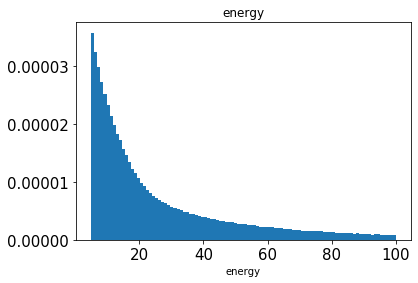

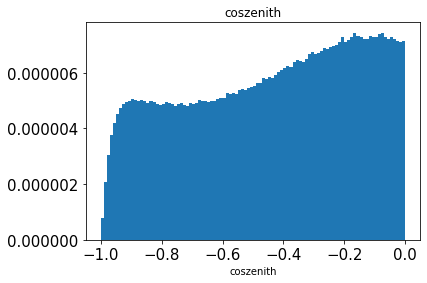

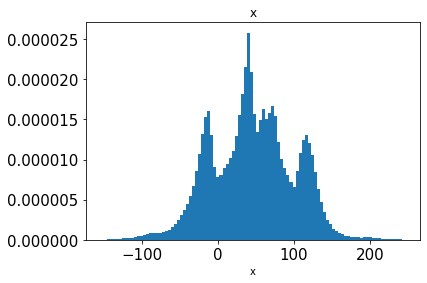

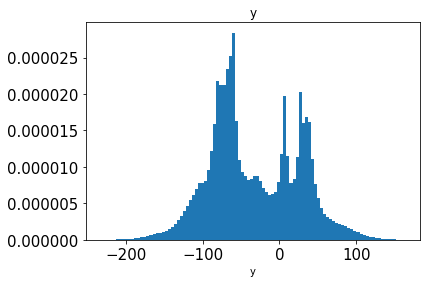

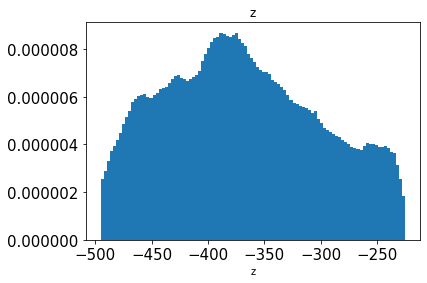

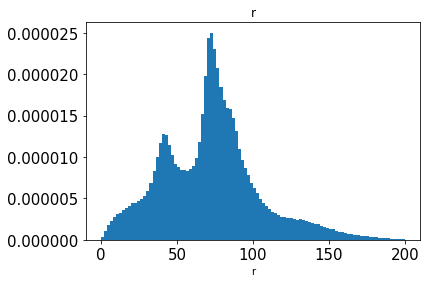

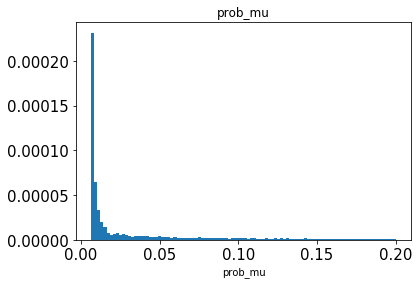

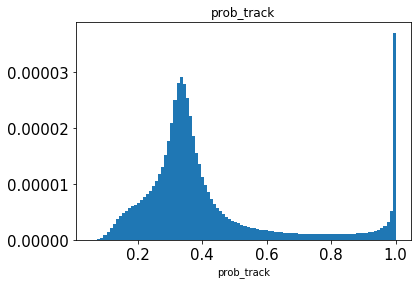

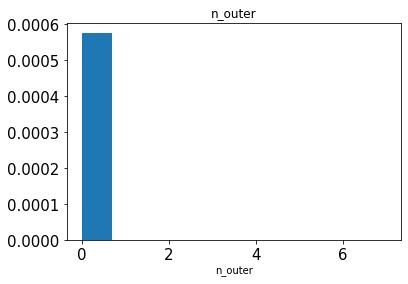

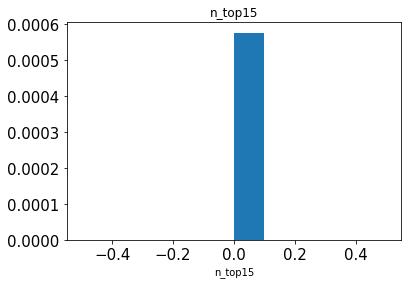

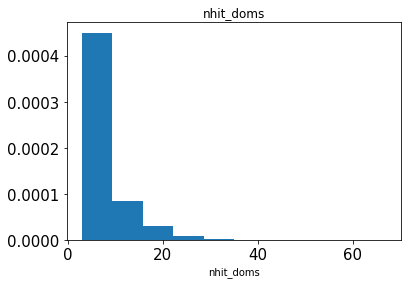

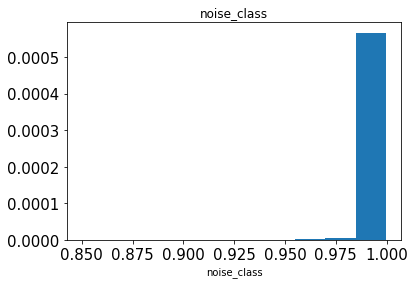

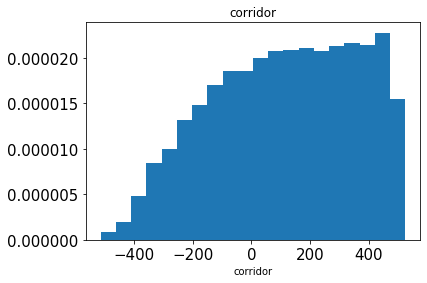

In [37]:
mask_here = mask1['Analysis']

check_vars = ["energy", "coszenith", "x", "y", "z", "r", "prob_mu", "prob_track"]
for check in check_vars:
    nan = math.isnan(reco1[check][mask_here][0])
    print(np.sum(nan))
    plt.figure()
    plt.title(check)
    plt.hist(reco1[check][mask_here],weights=weights1[mask_here],bins=100)
    plt.xlabel(check)

check_vars = ["n_outer","n_top15","nhit_doms", "noise_class"]
for check in check_vars:
    nan = math.isnan(more_info1[check][mask_here][0])
    print(np.sum(nan))
    plt.figure()
    plt.title(check)
    plt.hist(more_info1[check][mask_here],weights=weights1[mask_here],bins=10)
    plt.xlabel(check)

check="corridor"
nan = math.isnan(true1[check][mask_here][0])
print(np.sum(nan))
plt.figure()
plt.title(check)
plt.hist(true1[check][mask_here],weights=weights1[mask_here],bins=20)
plt.xlabel(check)

Text(0.5, 0, 'Cosine Zenith')

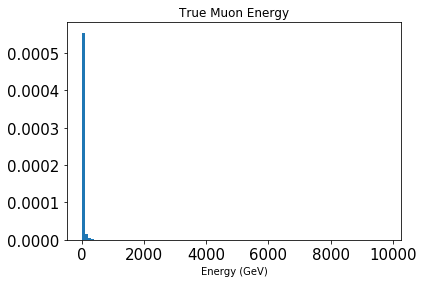

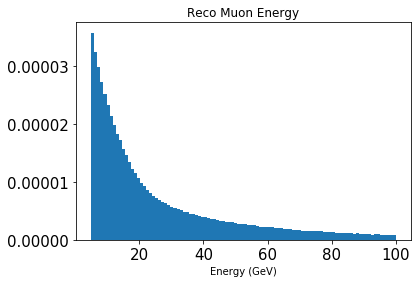

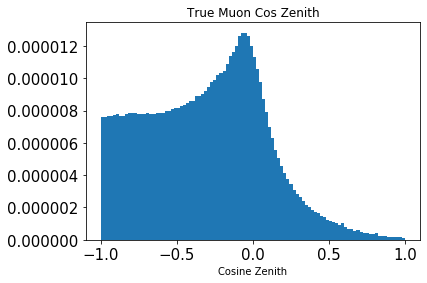

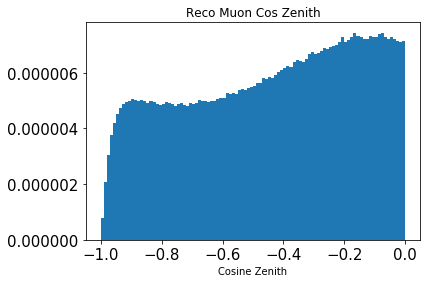

In [14]:
mask_here = mask1['Analysis']

plt.figure()
plt.title("True Muon Energy")
plt.hist(true1['energy'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title("Reco Muon Energy")
plt.hist(reco1['energy'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title("True Muon Cos Zenith")
plt.hist(true1['coszenith'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Cosine Zenith")

plt.figure()
plt.title("Reco Muon Cos Zenith")
plt.hist(reco1['coszenith'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Cosine Zenith")

Text(0.5, 0, 'Cosine Zenith')

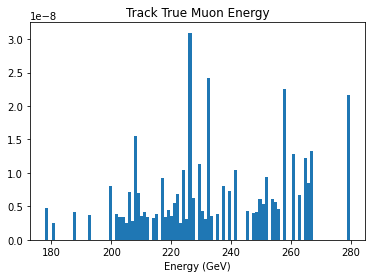

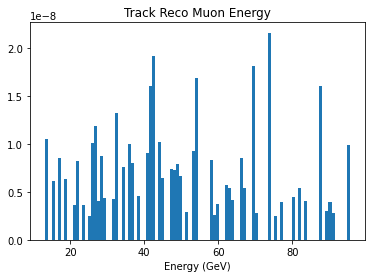

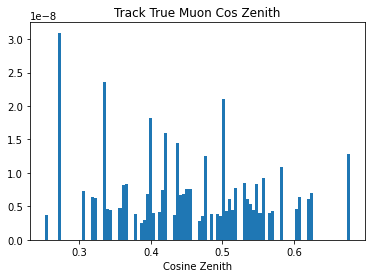

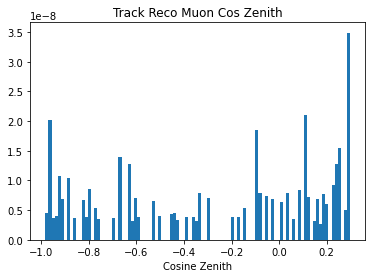

In [46]:
mask_here = np.logical_and(mask1['Analysis'],reco_track)
m = "Track "

plt.figure()
plt.title(m + "True Muon Energy")
plt.hist(true1['energy'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title(m + "Reco Muon Energy")
plt.hist(reco1['energy'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title(m + "True Muon Cos Zenith")
plt.hist(true1['coszenith'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Cosine Zenith")

plt.figure()
plt.title(m + "Reco Muon Cos Zenith")
plt.hist(reco1['coszenith'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Cosine Zenith")

Text(0.5, 0, 'Cosine Zenith')

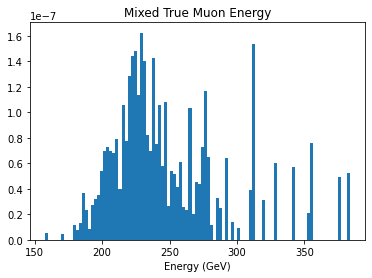

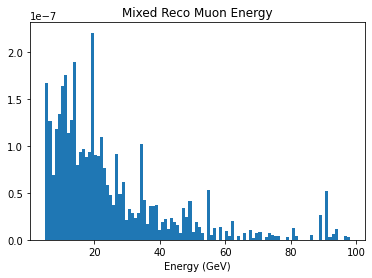

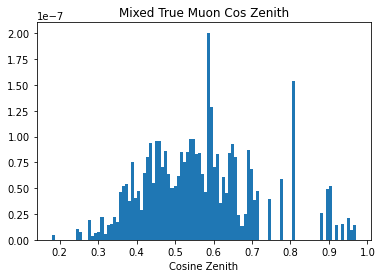

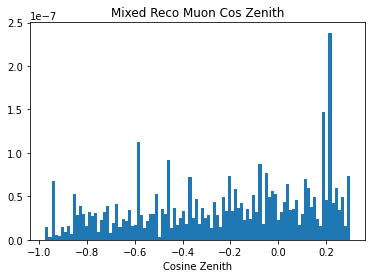

In [47]:
mask_here = np.logical_and(mask1['Analysis'],reco_mixed)
m = "Mixed "

plt.figure()
plt.title(m + "True Muon Energy")
plt.hist(true1['energy'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title(m + "Reco Muon Energy")
plt.hist(reco1['energy'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title(m + "True Muon Cos Zenith")
plt.hist(true1['coszenith'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Cosine Zenith")

plt.figure()
plt.title(m + "Reco Muon Cos Zenith")
plt.hist(reco1['coszenith'][mask_here],weights=weights1[mask_here],bins=100)
plt.xlabel("Cosine Zenith")

Text(0.5, 0, 'Cosine Zenith')

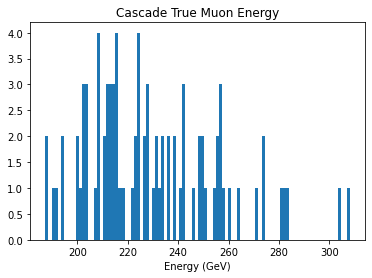

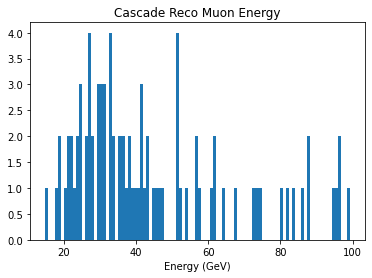

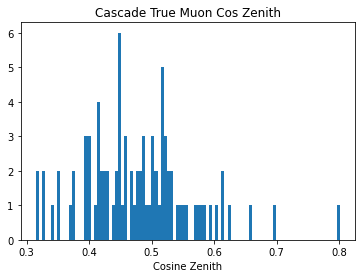

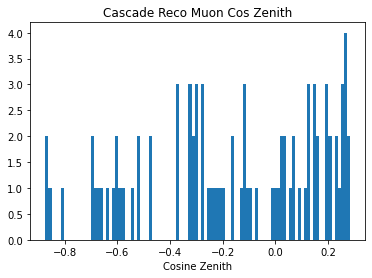

In [49]:
mask_here = np.logical_and(mask1['Analysis'],reco_cascade)
m = "Cascade "

plt.figure()
plt.title(m + "True Muon Energy")
plt.hist(true1['energy'][mask_here],bins=100) #weights=weights1[mask_here],bins=100)
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title(m + "Reco Muon Energy")
plt.hist(reco1['energy'][mask_here],bins=100) #weights=weights1[mask_here],bins=100)
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title(m + "True Muon Cos Zenith")
plt.hist(true1['coszenith'][mask_here],bins=100) #weights=weights1[mask_here],bins=100)
plt.xlabel("Cosine Zenith")

plt.figure()
plt.title(m + "Reco Muon Cos Zenith")
plt.hist(reco1['coszenith'][mask_here],bins=100) #weights=weights1[mask_here],bins=100)
plt.xlabel("Cosine Zenith")

In [50]:
def plot_hist_given_hist(hist_here,label_factor=1,title="Counts",label_factor_title=None,pid="CNN Track",sample="",savepath=None):
    
    if label_factor_title is None:
        label_factor_title = str(label_factor)
    
    fig, ax = plt.subplots(figsize=(15,13))
    ax.set_title("%s: %s %s (label x %s)"%(title,sample,pid,label_factor_title),fontsize=25)
    im = ax.imshow(hist_here,origin='lower', cmap='viridis_r')
    fig.colorbar(im, orientation='vertical')
    ax.set_xlabel("CNN Energy (GeV)",fontsize=20)
    ax.set_ylabel("CNN Cos Zenith",fontsize=20)

    xlabels=[]
    for i in range(0,len(energy_bins)):
        if i%2==0:
            xlabels.append("%.2f"%energy_bins[i])
    ylabels=[]
    for i in range(0,len(coszen_bins)):
        if i%2==0:
            ylabels.append("%.2f"%coszen_bins[i])
    ax.set_xticks([-0.5,1.5,3.5,5.5,7.5,9.5,11.5])
    ax.set_yticks([-0.5,1.5,3.5,5.5,7.5,9.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    
    maxhist = np.nanmax(hist_here)
    minhist = np.nanmin(hist_here)
    half = (maxhist-minhist)/2.
    half_point = maxhist - half
    for i in range(len(ybins)-1):
        for j in range(len(xbins)-1):
            c="k"
            #total = sum(weights1[mask])
            events = hist_here[i,j]
            if events > half_point:
                c="w"
            s = "%.2f"%(events*label_factor)
            ax.text(j, i,"%s"%s, 
                    color=c, ha="center", va="center",fontsize=15)
    savename = title.replace(" ","")
    savename += pid.replace(" ","")
    savename += sample.replace(" ","")
    plt.savefig("%s/%s.png"%(savepath,savename))

In [54]:
path=save_folder_name

In [51]:
coszen_bins = np.linspace(-1,0.3,11)
energy_bins = np.logspace(0.699,2,13)

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


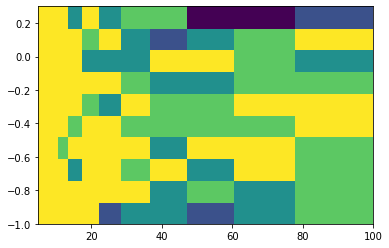

In [55]:
mask = np.logical_and(reco_track, mask1["Analysis"]) 

hist, xbins, ybins, im = plt.hist2d(reco1['energy'][mask],reco1['coszenith'][mask],
                                    weights=weights1[mask],bins=[energy_bins,coszen_bins],
                                    cmap='viridis_r',cmin=0); #,norm=colors.LogNorm())

hist2, xbins, ybins, im = plt.hist2d(reco1['energy'][mask],reco1['coszenith'][mask],
                                    weights=(weights1[mask]*weights1[mask]),bins=[energy_bins,coszen_bins],
                                    cmap='viridis_r',cmin=0); #,norm=colors.LogNorm())

hist3, xbins, ybins, im = plt.hist2d(reco1['energy'][mask],reco1['coszenith'][mask],
                                    weights=None,bins=[energy_bins,coszen_bins],
                                    cmap='viridis_r',cmin=0);

hist_unweighted1 = hist3
hist_weights1 = hist
hist_weights_squared1 = hist2
hist_sqrt_weights_squared1 = np.sqrt(hist_weights_squared1)
hist_sqrt_weights_squared_per_weight1 = hist_sqrt_weights_squared1/hist_weights1

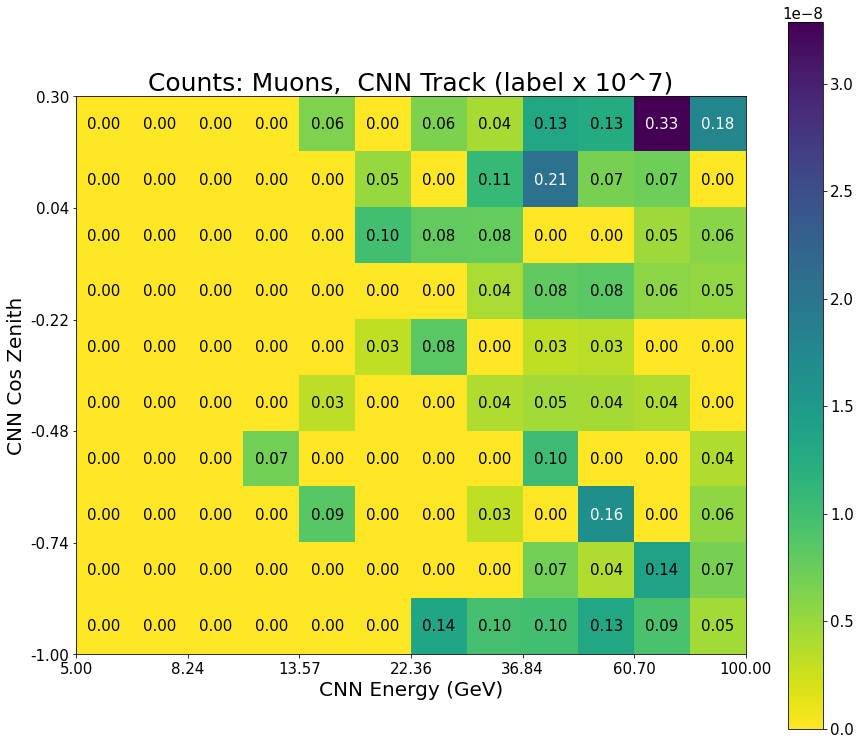

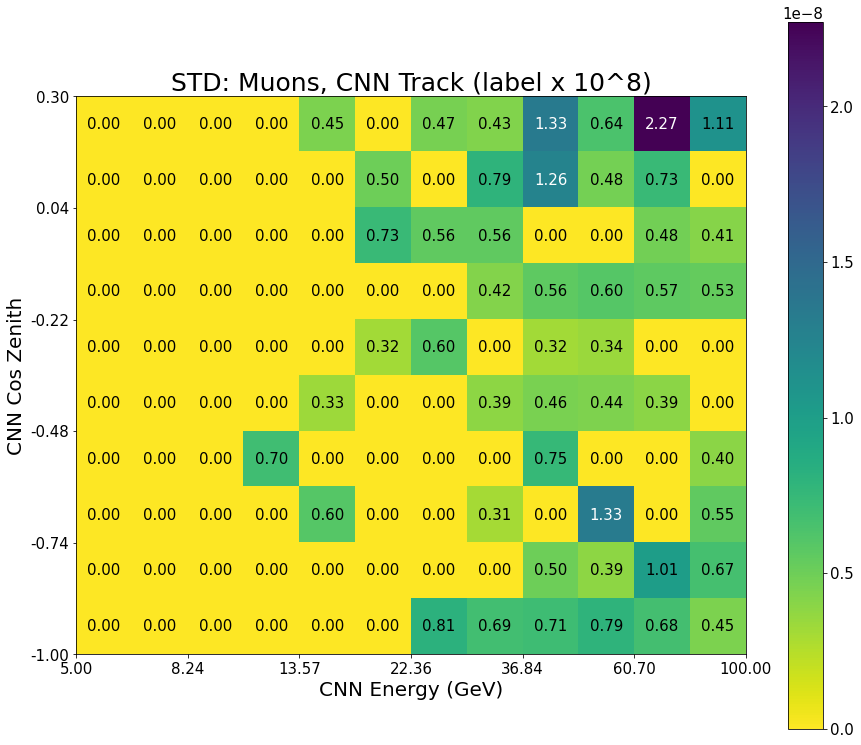

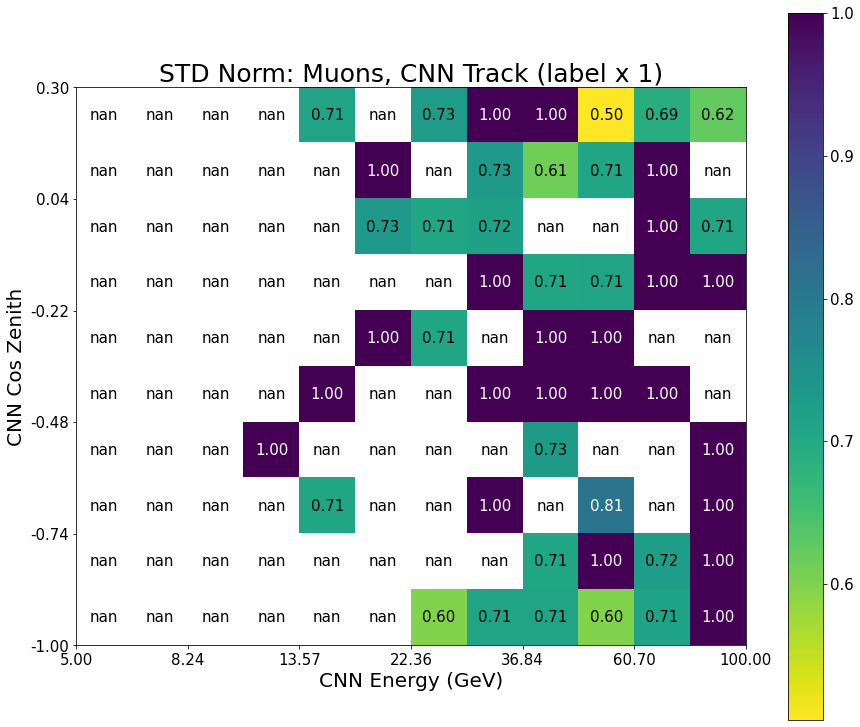

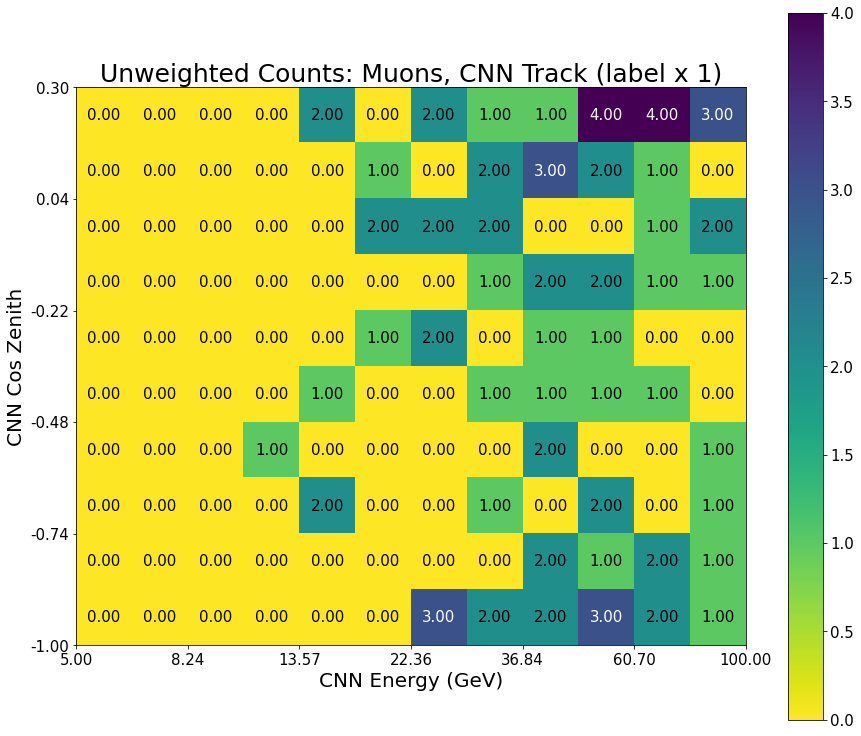

In [59]:
plot_hist_given_hist(hist_weights1.T,1e7,"Counts",label_factor_title="10^7",pid="CNN Track",savepath=path,sample="Muons, ")
plot_hist_given_hist(hist_sqrt_weights_squared1.T,1e8,"STD",label_factor_title="10^8",pid="CNN Track",savepath=path,sample="Muons,")
plot_hist_given_hist(hist_sqrt_weights_squared_per_weight1.T,1,"STD Norm",label_factor_title="1",pid="CNN Track",savepath=path,sample="Muons,")
plot_hist_given_hist(hist_unweighted1.T,1,"Unweighted Counts",label_factor_title="1",pid="CNN Track",savepath=path,sample="Muons,")

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


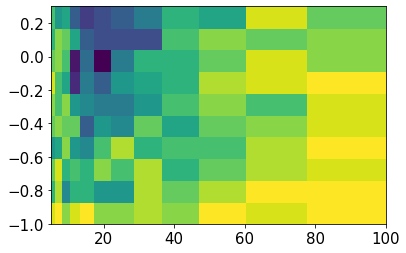

In [60]:
mask = np.logical_and(reco_mixed, mask1["Analysis"]) 

hist, xbins, ybins, im = plt.hist2d(reco1['energy'][mask],reco1['coszenith'][mask],
                                    weights=weights1[mask],bins=[energy_bins,coszen_bins],
                                    cmap='viridis_r',cmin=0); #,norm=colors.LogNorm())

hist2, xbins, ybins, im = plt.hist2d(reco1['energy'][mask],reco1['coszenith'][mask],
                                    weights=(weights1[mask]*weights1[mask]),bins=[energy_bins,coszen_bins],
                                    cmap='viridis_r',cmin=0); #,norm=colors.LogNorm())

hist3, xbins, ybins, im = plt.hist2d(reco1['energy'][mask],reco1['coszenith'][mask],
                                    weights=None,bins=[energy_bins,coszen_bins],
                                    cmap='viridis_r',cmin=0);

hist_unweighted1 = hist3
hist_weights1 = hist
hist_weights_squared1 = hist2
hist_sqrt_weights_squared1 = np.sqrt(hist_weights_squared1)
hist_sqrt_weights_squared_per_weight1 = hist_sqrt_weights_squared1/hist_weights1

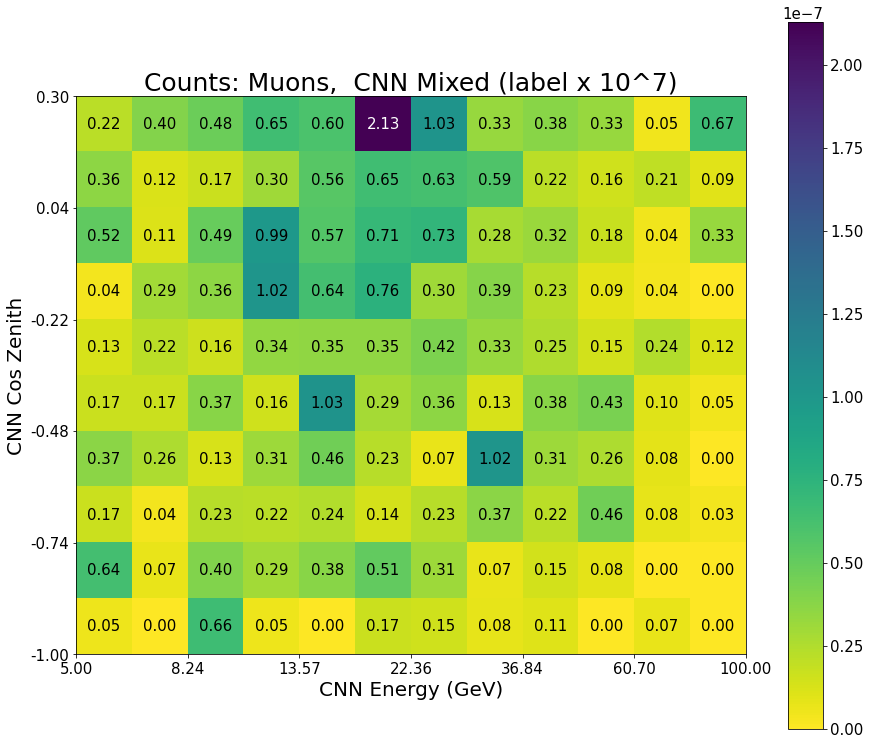

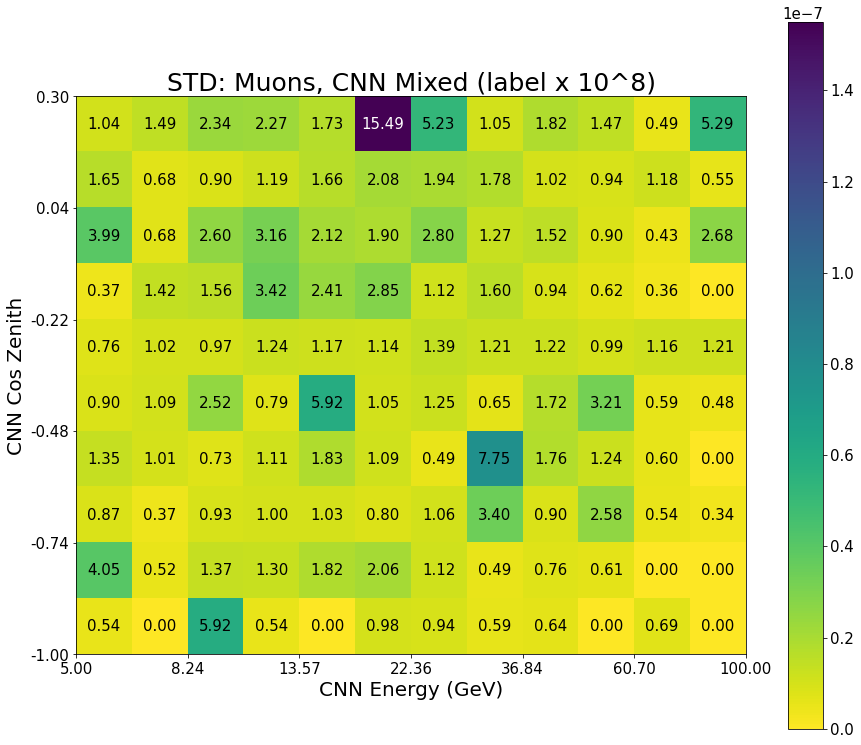

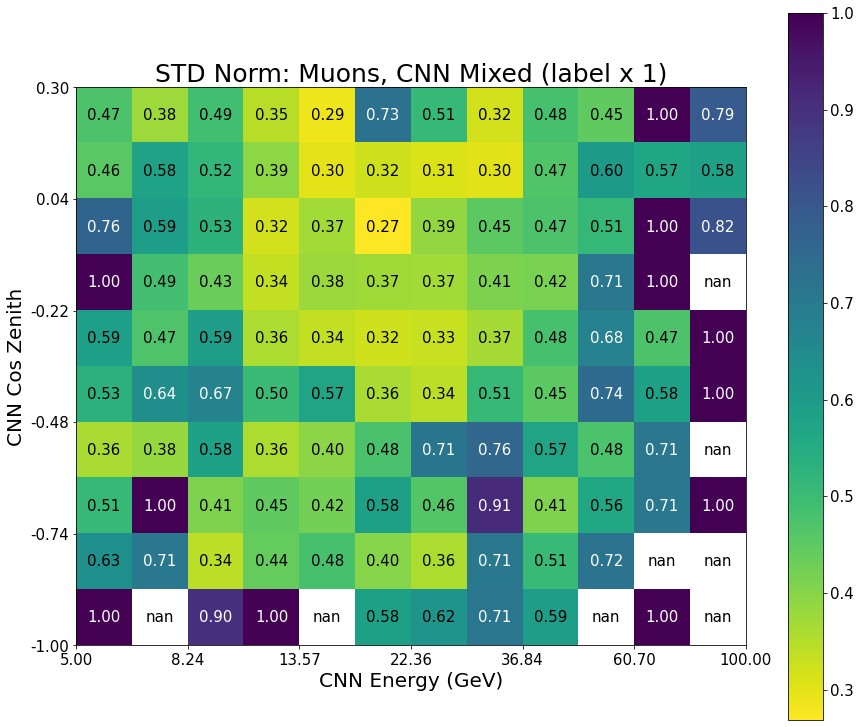

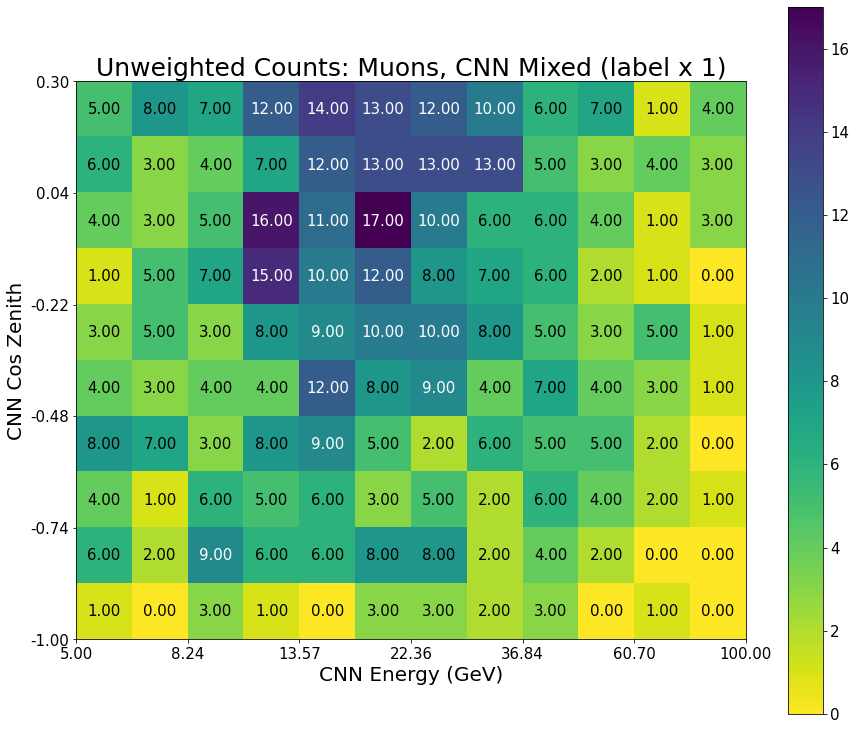

In [61]:
plot_hist_given_hist(hist_weights1.T,1e7,"Counts",label_factor_title="10^7",pid="CNN Mixed",savepath=path,sample="Muons, ")
plot_hist_given_hist(hist_sqrt_weights_squared1.T,1e8,"STD",label_factor_title="10^8",pid="CNN Mixed",savepath=path,sample="Muons,")
plot_hist_given_hist(hist_sqrt_weights_squared_per_weight1.T,1,"STD Norm",label_factor_title="1",pid="CNN Mixed",savepath=path,sample="Muons,")
plot_hist_given_hist(hist_unweighted1.T,1,"Unweighted Counts",label_factor_title="1",pid="CNN Mixed",savepath=path,sample="Muons,")

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


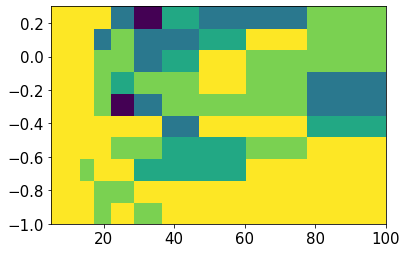

In [62]:
mask = np.logical_and(reco_cascade, mask1["Analysis"]) 

hist, xbins, ybins, im = plt.hist2d(reco1['energy'][mask],reco1['coszenith'][mask],
                                    weights=weights1[mask],bins=[energy_bins,coszen_bins],
                                    cmap='viridis_r',cmin=0); #,norm=colors.LogNorm())

hist2, xbins, ybins, im = plt.hist2d(reco1['energy'][mask],reco1['coszenith'][mask],
                                    weights=(weights1[mask]*weights1[mask]),bins=[energy_bins,coszen_bins],
                                    cmap='viridis_r',cmin=0); #,norm=colors.LogNorm())

hist3, xbins, ybins, im = plt.hist2d(reco1['energy'][mask],reco1['coszenith'][mask],
                                    weights=None,bins=[energy_bins,coszen_bins],
                                    cmap='viridis_r',cmin=0);

hist_unweighted1 = hist3
hist_weights1 = hist
hist_weights_squared1 = hist2
hist_sqrt_weights_squared1 = np.sqrt(hist_weights_squared1)
hist_sqrt_weights_squared_per_weight1 = hist_sqrt_weights_squared1/hist_weights1

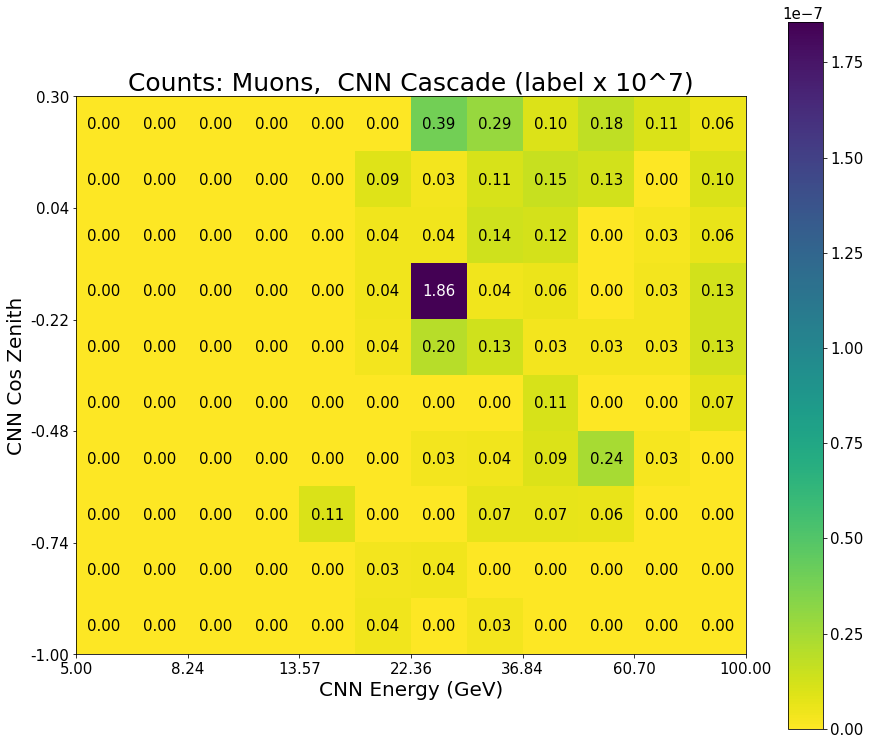

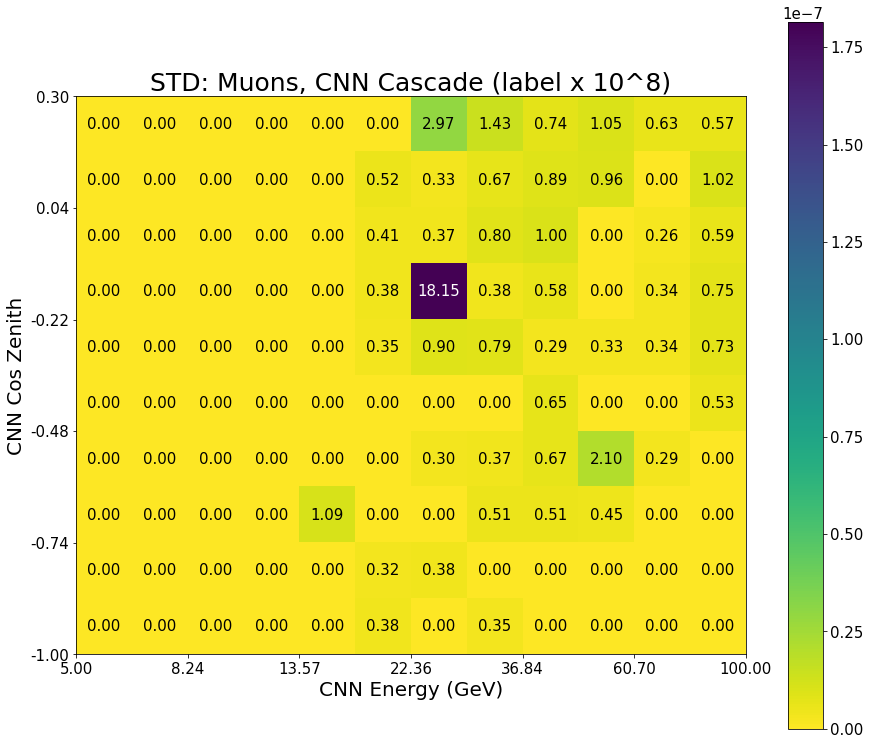

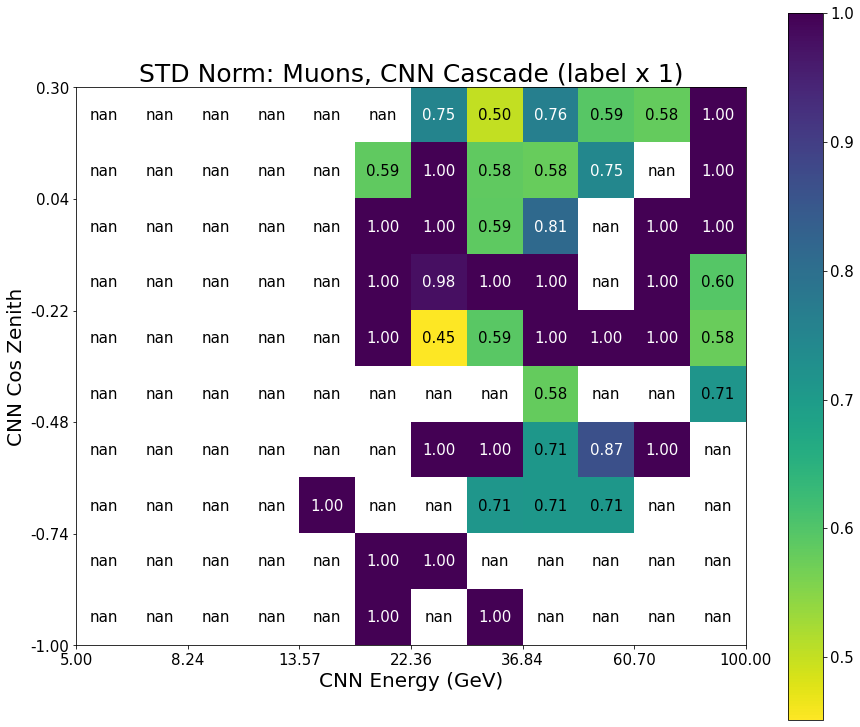

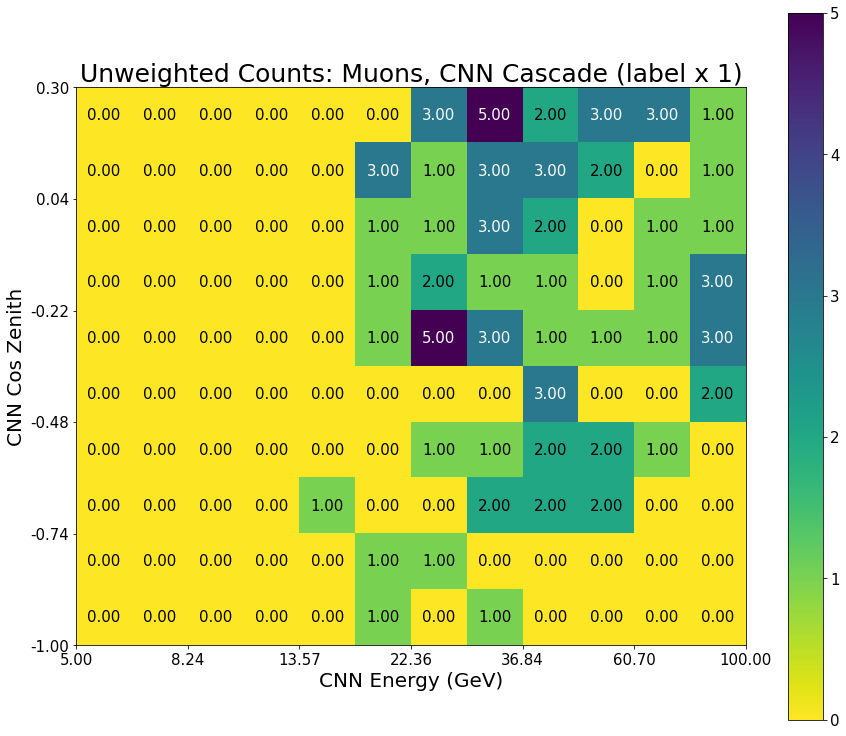

In [63]:
plot_hist_given_hist(hist_weights1.T,1e7,"Counts",label_factor_title="10^7",pid="CNN Cascade",savepath=path,sample="Muons, ")
plot_hist_given_hist(hist_sqrt_weights_squared1.T,1e8,"STD",label_factor_title="10^8",pid="CNN Cascade",savepath=path,sample="Muons,")
plot_hist_given_hist(hist_sqrt_weights_squared_per_weight1.T,1,"STD Norm",label_factor_title="1",pid="CNN Cascade",savepath=path,sample="Muons,")
plot_hist_given_hist(hist_unweighted1.T,1,"Unweighted Counts",label_factor_title="1",pid="CNN Cascade",savepath=path,sample="Muons,")

19


Text(0.5, 0, 'z (m)')

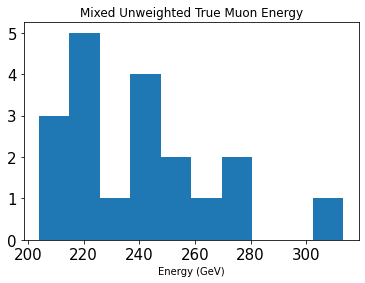

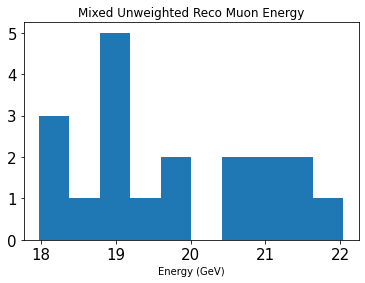

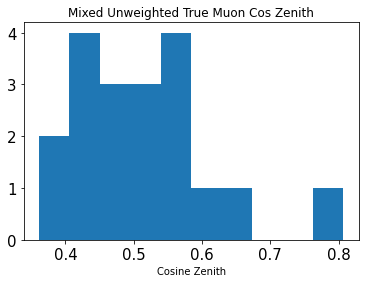

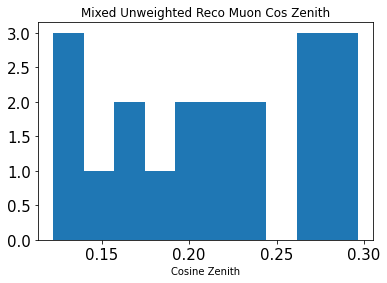

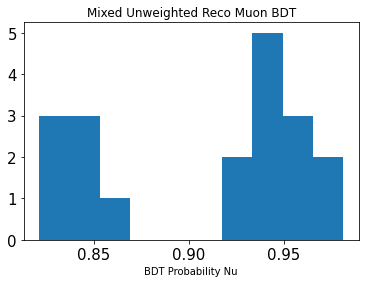

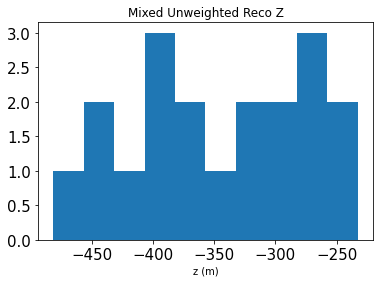

In [85]:
ecut = np.logical_and(reco1['energy'] > 17.42141127, reco1['energy'] < 22.36145199)
zcut = np.logical_and(reco1['coszenith'] > 0.12, reco1['coszenith'] < 0.30)
mask_here = np.logical_and(np.logical_and(np.logical_and(mask1['Analysis'],reco_mixed), ecut), zcut)
print(sum(mask_here))
m = "Mixed Unweighted "
bins = 10
plt.figure()
plt.title(m + "True Muon Energy")
plt.hist(true1['energy'][mask_here],bins=bins) #weights=weights1[mask_here],bins=100)
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title(m + "Reco Muon Energy")
plt.hist(reco1['energy'][mask_here],bins=bins) #weights=weights1[mask_here],bins=100)
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title(m + "True Muon Cos Zenith")
plt.hist(true1['coszenith'][mask_here],bins=bins) #weights=weights1[mask_here],bins=100)
plt.xlabel("Cosine Zenith")

plt.figure()
plt.title(m + "Reco Muon Cos Zenith")
plt.hist(reco1['coszenith'][mask_here],bins=bins) #weights=weights1[mask_here],bins=100)
plt.xlabel("Cosine Zenith")

plt.figure()
plt.title(m + "Reco Muon BDT")
plt.hist(reco1['prob_nu'][mask_here],bins=bins)
plt.xlabel("BDT Probability Nu")

#plt.figure()
#plt.title(m + "Reco R")
#plt.hist(reco1['r'][mask_here],bins=bins)
#plt.xlabel("rho_36 (m)")

plt.figure()
plt.title(m + "Reco Z")
plt.hist(reco1['z'][mask_here],bins=bins)
plt.xlabel("z (m)")

Text(0.5, 0, 'z (m)')

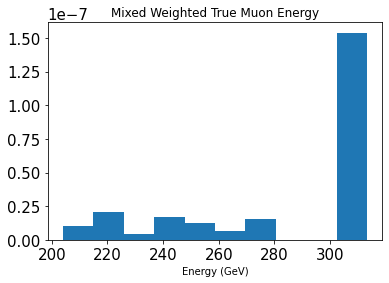

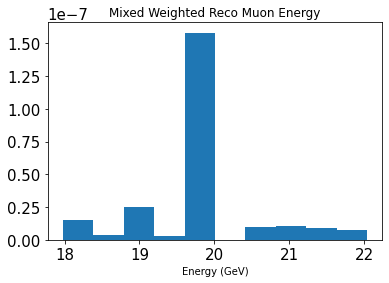

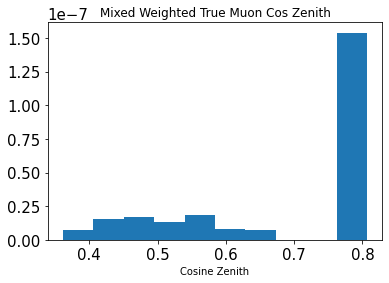

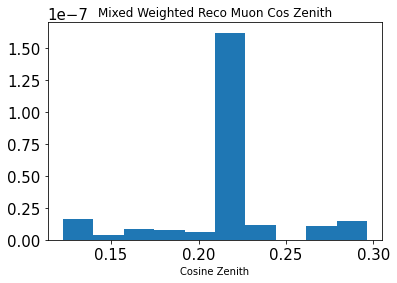

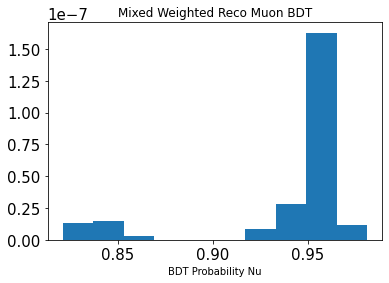

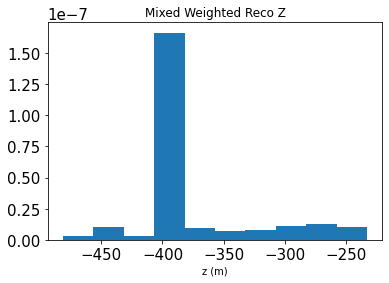

In [87]:
mask_here = np.logical_and(np.logical_and(np.logical_and(mask1['Analysis'],reco_mixed), ecut), zcut)
m = "Mixed Weighted "
bins = 10
plt.figure()
plt.title(m + "True Muon Energy")
plt.hist(true1['energy'][mask_here],bins=bins,weights=weights1[mask_here])
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title(m + "Reco Muon Energy")
plt.hist(reco1['energy'][mask_here],bins=bins,weights=weights1[mask_here])
plt.xlabel("Energy (GeV)")

plt.figure()
plt.title(m + "True Muon Cos Zenith")
plt.hist(true1['coszenith'][mask_here],bins=bins,weights=weights1[mask_here])
plt.xlabel("Cosine Zenith")

plt.figure()
plt.title(m + "Reco Muon Cos Zenith")
plt.hist(reco1['coszenith'][mask_here],bins=bins,weights=weights1[mask_here])
plt.xlabel("Cosine Zenith")

plt.figure()
plt.title(m + "Reco Muon BDT")
plt.hist(reco1['prob_nu'][mask_here],bins=bins,weights=weights1[mask_here])
plt.xlabel("BDT Probability Nu")

#plt.figure()
#plt.title(m + "Reco R")
#plt.hist(reco1['r'][mask_here],bins=bins,weights=weights1[mask_here])
#plt.xlabel("rho_36 (m)")

plt.figure()
plt.title(m + "Reco Z")
plt.hist(reco1['z'][mask_here],bins=bins,weights=weights1[mask_here])
plt.xlabel("z (m)")

In [72]:
print(energy_bins)

[  5.00034535   6.41825055   8.23821901  10.57426037  13.57271302
  17.42141127  22.36145199  28.70229783  36.84116315  47.28789696
  60.69692179  77.90822922 100.        ]


Text(0.5, 0, 'Weights')

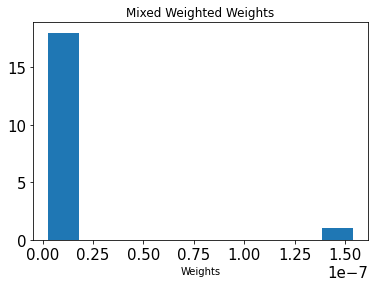

In [88]:
plt.figure()
plt.title(m + "Weights")
plt.hist(weights1[mask_here],bins=bins)
plt.xlabel("Weights")

In [89]:
print(weights1[mask_here])

[4.95289066e-09 7.61623969e-09 6.85132391e-09 6.48680858e-09
 1.53856361e-07 3.77306609e-09 3.46224198e-09 4.17465487e-09
 8.34592873e-09 2.97405180e-09 2.94577974e-09 2.92920136e-09
 2.91012499e-09 3.63022267e-09 5.98600990e-09 7.30268618e-09
 4.45754835e-09 4.78711375e-09 3.93824816e-09]


In [106]:
w = np.array(weights1)
find = np.logical_and(w>1.538e-07,w<1.539e-07)

In [107]:
np.where(find==1)

(array([44599]),)

In [111]:
for key in particle['muon'].keys():
    print(key, particle['muon'][key][44599])

FLERCNN_BDT_ProbNu 0.9552719877171321
FLERCNN_coszen 0.21301979112201233
FLERCNN_energy 19.748789072036743
FLERCNN_nDOM 14.0
FLERCNN_prob_muon_v3 0.0013200342655181885
FLERCNN_prob_nu 0.9999517798423767
FLERCNN_prob_track 0.3520694375038147
FLERCNN_vertex_rho36 60.99469098486475
FLERCNN_vertex_x 98.55928802490234
FLERCNN_vertex_y -66.31682586669922
FLERCNN_vertex_z -385.5438232421875
I3EventHeader.event_id 86486
I3EventHeader.run_id 130000
I3EventHeader.start_time.mod_julian_day_double 56783.91536351205
I3EventHeader.sub_event_id 0
I3EventHeader.sub_run_id 5379
I3MCWeightDict.weight 1.5385636094721795e-07
IC2018_LE_L3_Vars.C2HR6 0.6923076923076923
IC2018_LE_L3_Vars.CausalVetoHits 2.0
IC2018_LE_L3_Vars.CleanedFullTimeLength 1382.0
IC2018_LE_L3_Vars.DCFiducialHits 15.0
IC2018_LE_L3_Vars.Data_quality 1.0
IC2018_LE_L3_Vars.FullTimeLengthRatio 0.13728022250918845
IC2018_LE_L3_Vars.ICVetoHits 0.0
IC2018_LE_L3_Vars.NAbove200Hits 5.0
IC2018_LE_L3_Vars.N_LIDErrata 0.0
IC2018_LE_L3_Vars.NchClean

In [10]:
zmin_nan = np.isnan(true1['corridor'])

In [11]:
muon_zmin_nan = np.logical_and(np.logical_and(zmin_nan,mask1['Analysis']),true1['isMuon'])
muon_zmin_notnan = np.logical_and(np.logical_and(np.logical_not(zmin_nan),mask1['Analysis']),true1['isMuon'])

In [12]:
nu_zmin_nan = np.logical_and(np.logical_and(zmin_nan,mask1['Analysis']),true1['isNu'])
nu_zmin_notnan = np.logical_and(np.logical_and(np.logical_not(zmin_nan),mask1['Analysis']),true1['isNu'])

Text(0.5, 0, 'BDT Probability Nu')

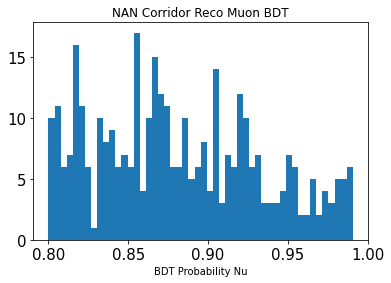

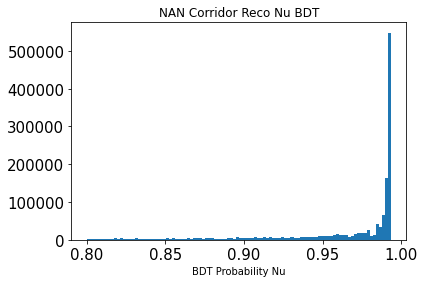

In [15]:
mask_here = muon_zmin_nan
m = "NAN Corridor "
bins=50
plt.figure()
plt.title(m + "Reco Muon BDT")
plt.hist(reco1['prob_nu'][mask_here],bins=bins) #,weights=weights1[mask_here])
plt.xlabel("BDT Probability Nu")

bins=100
mask_here = nu_zmin_nan
plt.figure()
plt.title(m + "Reco Nu BDT")
plt.hist(reco1['prob_nu'][mask_here],bins=bins) #,weights=weights1[mask_here])
plt.xlabel("BDT Probability Nu")

In [39]:
sum(np.logical_and(mask1['Analysis'],true1['isMuon']))

944

In [40]:
sum(np.logical_and(np.logical_and(zmin_nan,mask1['Analysis']),true1['isNu']))

1278540

In [41]:
sum(np.logical_and(mask1['Analysis'],true1['isNu']))

2698253

In [24]:
sum(np.logical_and(np.logical_and(zmin_nan,mask1['Analysis']),true1['isNuMu']))

758699

In [23]:
big_weights = weights1 > 1e-7
big_muons = np.logical_and(true1['isMuon'],big_weights)

In [24]:
sum(np.logical_and(big_muons, mask1['Analysis']))

2

In [25]:
sum(big_muons)

408

In [27]:
find_mu = np.logical_and(big_muons, mask1['Analysis'])

In [28]:
np.where(find_mu)

(array([44599, 90774]),)

In [30]:
for key in particle['muon'].keys():
    print(key, particle['muon'][key][90774])

FLERCNN_BDT_ProbNu 0.8594626514736395
FLERCNN_coszen -0.1663196807325592
FLERCNN_energy 27.90866196155548
FLERCNN_nDOM 17.0
FLERCNN_prob_muon_v3 0.0012857913970947266
FLERCNN_prob_nu 0.9904511570930481
FLERCNN_prob_track 0.1357547640800476
FLERCNN_vertex_rho36 34.972867729864355
FLERCNN_vertex_x 70.13849639892578
FLERCNN_vertex_y -9.299720764160156
FLERCNN_vertex_z -233.84066772460938
I3EventHeader.event_id 184843
I3EventHeader.run_id 130000
I3EventHeader.start_time.mod_julian_day_double 56783.91536351205
I3EventHeader.sub_event_id 0
I3EventHeader.sub_run_id 13019
I3MCWeightDict.weight 1.8142802944169153e-07
IC2018_LE_L3_Vars.C2HR6 0.8
IC2018_LE_L3_Vars.CausalVetoHits 4.0
IC2018_LE_L3_Vars.CleanedFullTimeLength 921.0
IC2018_LE_L3_Vars.DCFiducialHits 17.0
IC2018_LE_L3_Vars.Data_quality 1.0
IC2018_LE_L3_Vars.FullTimeLengthRatio 0.09838692447388099
IC2018_LE_L3_Vars.ICVetoHits 0.0
IC2018_LE_L3_Vars.NAbove200Hits 2.0
IC2018_LE_L3_Vars.N_LIDErrata 0.0
IC2018_LE_L3_Vars.NchCleaned 17.0
IC201

In [15]:
find_mu_track = np.logical_and(np.logical_and(true1['isMuon'], mask1['Analysis']), reco_track)
print(np.argmax(weights1[find_mu_track]),np.max(weights1[find_mu_track]))

9 2.1574549887299648e-08


Text(0.5, 0, 'Weights')

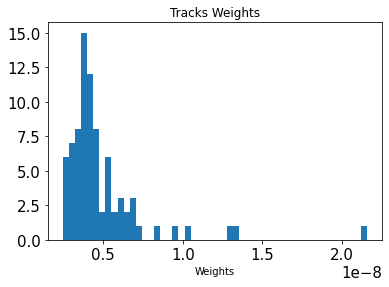

In [20]:
m = "Tracks "
mask_here = find_mu_track
bins=50
plt.figure()
plt.title(m + "Weights")
plt.hist(weights1[mask_here],bins=bins)
plt.xlabel("Weights")

In [17]:
w = np.array(weights1)
f_mu_t = np.logical_and(w > 2.157454988729964e-08, w < 2.157454988729965e-08)
np.where(f_mu_t)

(array([24990]),)

In [18]:
for key in particle['muon'].keys():
    print(key, particle['muon'][key][24990])

FLERCNN_BDT_ProbNu 0.991005941164399
FLERCNN_coszen 0.2975246398983127
FLERCNN_energy 73.76284003257751
FLERCNN_nDOM 49.0
FLERCNN_prob_muon_v3 1.7076730728149414e-05
FLERCNN_prob_nu 0.9999998807907104
FLERCNN_prob_track 0.9998352527618408
FLERCNN_vertex_rho36 36.461203315153995
FLERCNN_vertex_x 9.948962211608887
FLERCNN_vertex_y -37.837745666503906
FLERCNN_vertex_z -270.821533203125
I3EventHeader.event_id 72715
I3EventHeader.run_id 130000
I3EventHeader.start_time.mod_julian_day_double 56783.91536351204
I3EventHeader.sub_event_id 0
I3EventHeader.sub_run_id 3018
I3MCWeightDict.weight 2.1574549887299648e-08
IC2018_LE_L3_Vars.C2HR6 0.6382978723404256
IC2018_LE_L3_Vars.CausalVetoHits 3.0
IC2018_LE_L3_Vars.CleanedFullTimeLength 2506.0
IC2018_LE_L3_Vars.DCFiducialHits 48.0
IC2018_LE_L3_Vars.Data_quality 1.0
IC2018_LE_L3_Vars.FullTimeLengthRatio 0.23767071320182095
IC2018_LE_L3_Vars.ICVetoHits 1.0
IC2018_LE_L3_Vars.NAbove200Hits 4.0
IC2018_LE_L3_Vars.N_LIDErrata 0.0
IC2018_LE_L3_Vars.NchCleane